# OrbiTrap Analysis
This Notebook shows on an example MS file of a fermentation the usage of the `orbitrapanalysis` package. You can find the documentation [here](orbitrapanalysis/README.md). If you have any questions, feel free to contact [simon.michau@rwth-aachen.de](mailto:simon.michau@rwth-aachen.de)

In [1]:
from orbitrapanalysis.orbitrapanalysis import *

PROJECT_DIR = Path.cwd().parent  # directory path to # /iambanalyses (project directory)

## Step 1: Convert .raw files to .mzML
If your MS files aren't already in .mzML format you have to convert them so they can be used here. There are several options for converting one or multiple .raw files to .mzML files and saving them to a directory. It is recommended to use `PROJECT_DIR.joinpath("some/path")` to specify the path to the file or directory, but you can also give the full path as a string. PROJECT_DIR is the directory path to the project directory (iambanalyses), so joinpath is used to specify the relative path.

Example for converting a single file `data.RAW` in the `OrbiTrap` subfolder and saving the converted file in the `Converted` subfolder:
- `convert_file(PROJECT_DIR.joinpath("Data/OrbiTrap/data.RAW"), PROJECT_DIR.joinpath("Data/OrbiTrap/Converted"))`

Example for converting a single file `data.RAW` in the `OrbiTrap` subfolder and saving the converted file in the `Converted` subfolder wit a new name:
- `convert_file(PROJECT_DIR.joinpath("Data/OrbiTrap/data.RAW"), PROJECT_DIR.joinpath("Data/OrbiTrap/Converted/example.mzML"))`

Example for converting all .raw files in a directory and storing them in a subfolder:
- `convert_file(PROJECT_DIR.joinpath("Data/OrbiTrap"), PROJECT_DIR.joinpath("Data/OrbiTrap/Converted"))`

Example for converting all .raw files in a directory and storing them in the same directory:
- `convert_file("Data/OrbiTrap")`

In [3]:
# Retrieving a sample raw-file from an OrbiTrap measurement. The file is ~2 GB large and download typically takes about 5 min.
!wget https://rwth-aachen.sciebo.de/s/InIz0cw9NcI4UeT/download -O {PROJECT_DIR}/Data/OrbiTrap/OT_Test.raw

--2023-06-07 08:20:19--  https://rwth-aachen.sciebo.de/s/InIz0cw9NcI4UeT/download
Resolving rwth-aachen.sciebo.de (rwth-aachen.sciebo.de)... 128.176.1.2
Connecting to rwth-aachen.sciebo.de (rwth-aachen.sciebo.de)|128.176.1.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1996667954 (1.9G) [application/octet-stream]
Saving to: ‘/home/ulf/Documents/2111_iambjudas/Data/OrbiTrap/OT_Test.raw’

/home/ulf/Documents 100%[===================>]   1.86G  6.35MB/s    in 5m 0s   

2023-06-07 08:25:19 (6.35 MB/s) - ‘/home/ulf/Documents/2111_iambjudas/Data/OrbiTrap/OT_Test.raw’ saved [1996667954/1996667954]



In [4]:
# Conversion of the raw-file to mzML format. The conversion typically takes 3 min
convert_file(PROJECT_DIR.joinpath("Data/OrbiTrap/OT_Test.raw"), PROJECT_DIR.joinpath("Data/OrbiTrap/Converted"))

[2023-06-07 08:25:39,520] INFO - Starting conversion of 'OT_Test.raw' ...


2023-06-07 08:25:39 INFO Started parsing /home/ulf/Documents/2111_iambjudas/Data/OrbiTrap/OT_Test.raw
2023-06-07 08:25:52 INFO Processing 16005 MS scans
10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 

2023-06-07 08:28:11 INFO Finished parsing /home/ulf/Documents/2111_iambjudas/Data/OrbiTrap/OT_Test.raw


[2023-06-07 08:28:11,717] INFO - 'OT_Test.raw' conversion completed!


2023-06-07 08:28:11 INFO Processing completed 0 errors, 0 warnings


## Step 2: Create an ExpData object

In [16]:
exp_data = ExpData(PROJECT_DIR.joinpath("Data/OrbiTrap/Converted/OT_Test.mzML"))

[2023-06-07 08:30:05,232] INFO - Loading '/home/ulf/Documents/2111_iambjudas/Data/OrbiTrap/Converted/OT_Test.mzML' ...
[2023-06-07 08:30:11,082] INFO - Successfully loaded '/home/ulf/Documents/2111_iambjudas/Data/OrbiTrap/Converted/OT_Test.mzML'


### Step 2.1: Subsample the data to reduce the size
Usually there are about 2-3 measurements per second in an original data set. With this knowledge estimate the number you want to use for subsampling.
*Example*: `fermentation.RAW` has a duration of ~12 hours, so subsampling with 60 will result in one measurement every 20-30 seconds)
It is highly recommended to subsample because for many of the following steps this can make a difference from several hours to a few seconds.

In [17]:
exp_data.subsample(60)

[2023-06-07 08:30:14,042] INFO - Subsampled dataframe. Now contains 267 time points instead of 16005.


### Step 2.2: Plot experiment stats to determine intensity threshold for filtering
After loading the .mzML file, it is a good idea to first plot some basic statistics to get an overview of the data. The following methods can be used for this:

- `plot_boxplot(showfliers_intensity=False, showfliers_mz=True)` plots a boxplot of the intensity and m/z values. Whether outliers are shown can be specified with the `showfliers_intensity` and `showfliers_mz` parameters. To save the plot, specify the `save_path` parameter with a path to the desired location. <span style="color:orange">This can be done for all plotting functions</span>.
- `plot_mz_intensity_histogram(n_bins=50)` plots a histogram of the intensity and m/z values. The number of bins can be specified with the `n_bins` parameter. If no value is given, the default value of 100 is used.
- `plot_intensity_distribution(n_bins=50, show_original=True)` plots a histogram of the intensity distribution. The number of bins can be specified with the `n_bins` parameter. If no value is given, the default value of 50 is used. If `show_original` is set to True, the original intensity distribution (without any later applied filters) is plotted as well.
- `plot_mz_distribution(n_bins=50, show_original=True)` works the same as `plot_intensity_distribution`, but for the m/z values.

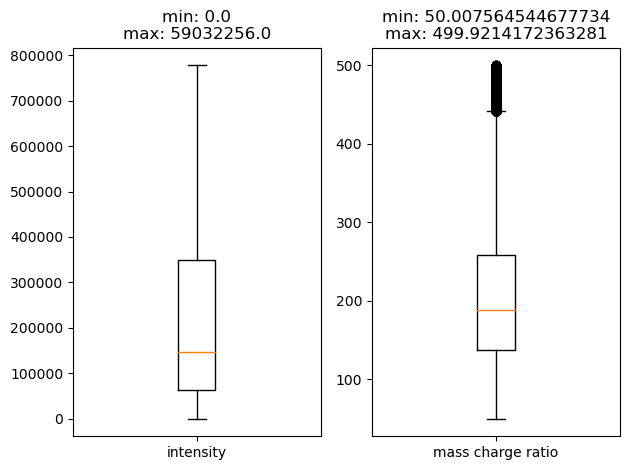

In [18]:
exp_data.plot_boxplot(showfliers_intensity=False)

### Step 2.3: Apply intensity filtering
<span style="color:orange">**Tip:**</span> It is recommended to at least set the filter to the upper limit of the boxplot (notice that the upper limit << maximum value), as usually the background noise is dominating the intensity distribution. Specifically for the scatter plots it is better to start with a high threshold and then lower it step by step until the desired features are visible.

In [21]:
exp_data.filter_by_intensity(min_intensity=3000000)

[2023-06-07 08:30:34,013] INFO - Filtering dataframe by intensity ...


  0%|          | 0/267 [00:00<?, ?it/s]

### Step 2.4: Plot Data to check if filtering worked as wanted
Repeat Step 2.3 until you are satisfied with the result. If you want to see the effect of the filtering, you can plot the data before and after filtering.

[2023-06-07 08:30:36,792] INFO - Plotting complete. Commencing rendering... Depending on the size of the dataset, this may take a while.


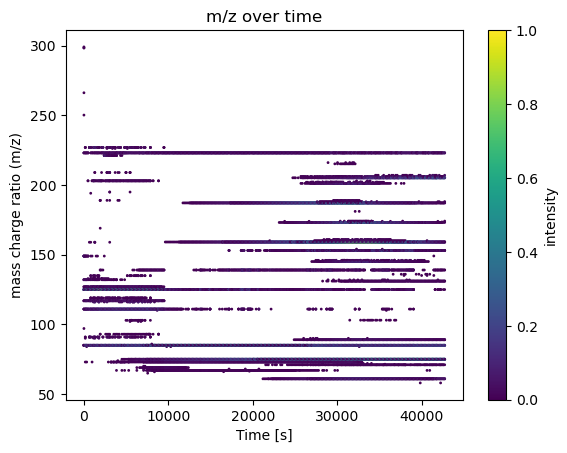

In [22]:
exp_data.scatter_plot()

### Step 2.5: Various useful plots
The following plots can be used in multiple ways. E.g. plotting the intensity distribution can help with picking the right intensity threshold for filtering. The number of features over time or the mean intensity over time can give you better insights into your experiment.

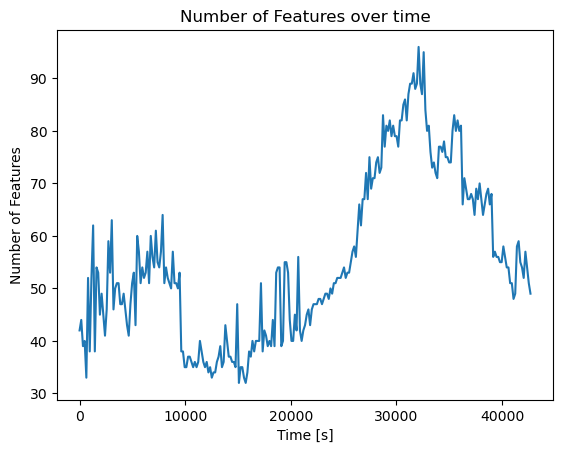

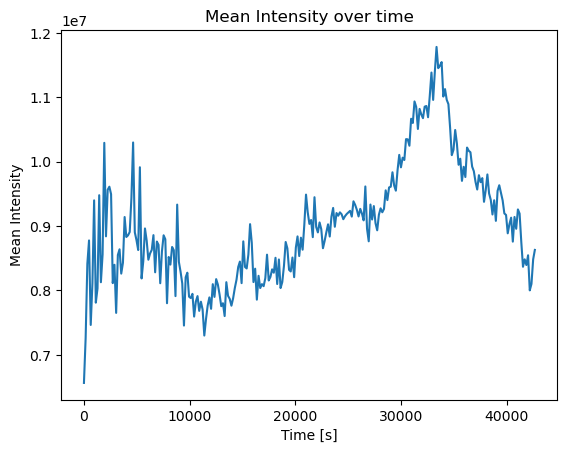

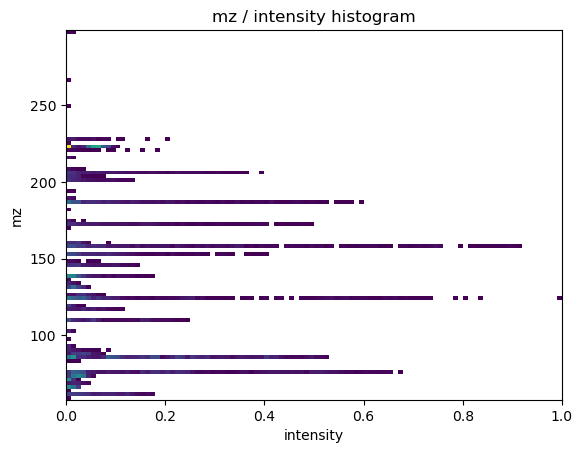

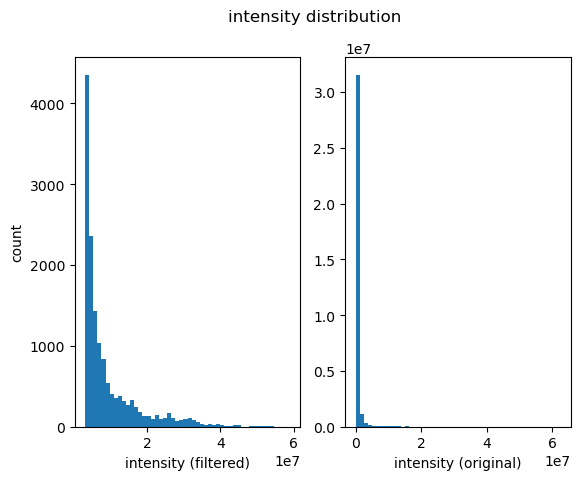

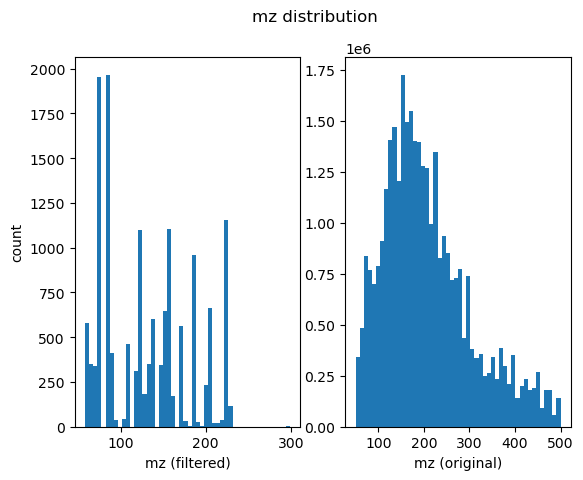

In [23]:
exp_data.plot_features_per_time()
exp_data.plot_mean_intensity_per_time()
exp_data.plot_mz_intensity_histogram()
exp_data.plot_intensity_distribution()
exp_data.plot_mz_distribution()

## Step 3: Create a FormattedData object
Once you are satisfied with the preprocessing you applied to the ExpData object, it is time to create a FormattedData object. This object will be used for further analysis.

In [33]:
formatted_data = FormattedData(exp_data, round_to_decimals=2)

[2023-06-07 08:35:15,922] INFO - Reformatting dataframe...


  0%|          | 0/267 [00:00<?, ?it/s]

[2023-06-07 08:35:16,424] INFO - Dataframe reformatting complete. Now concatenating columns... Depending on the size of the dataframe, this may take a while.
[2023-06-07 08:35:16,455] INFO - Concatenation complete.


Shape of reformatted dataframe: (310, 267) (mz values x time points)


### Step 3.1: Filter out control samples
If you included control samples in your experiment, now you can filter them out. Specifying the time interval of the control sample results in all mz traces that are prevalent in the control sample to be filtered out over the whole duration of the dataset. In case you only want to filter certain time intervals or mz ranges, use `filter_mz()` and `filter_time()` instead.

In [11]:
formatted_data.filter_control_samples((10000, 15000))

Old table size: (20, 224) Table size filtered by control sample: (19, 224)


### Step 3.2: Check if filtering worked as wanted

[2023-06-07 08:35:21,266] INFO - Plotting scatter plot...


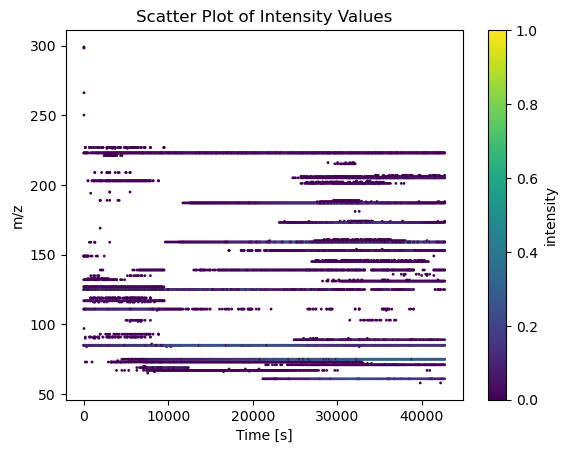

In [34]:
formatted_data.scatter_plot()

### Step 3.3: Cluster the traces
You can perform hierarchical clustering on the data. The resulting dendrogram will also be shown. You may want to standardize or normalize the data before plotting it.

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

/home/ulf/anaconda3/envs/olga_py39/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


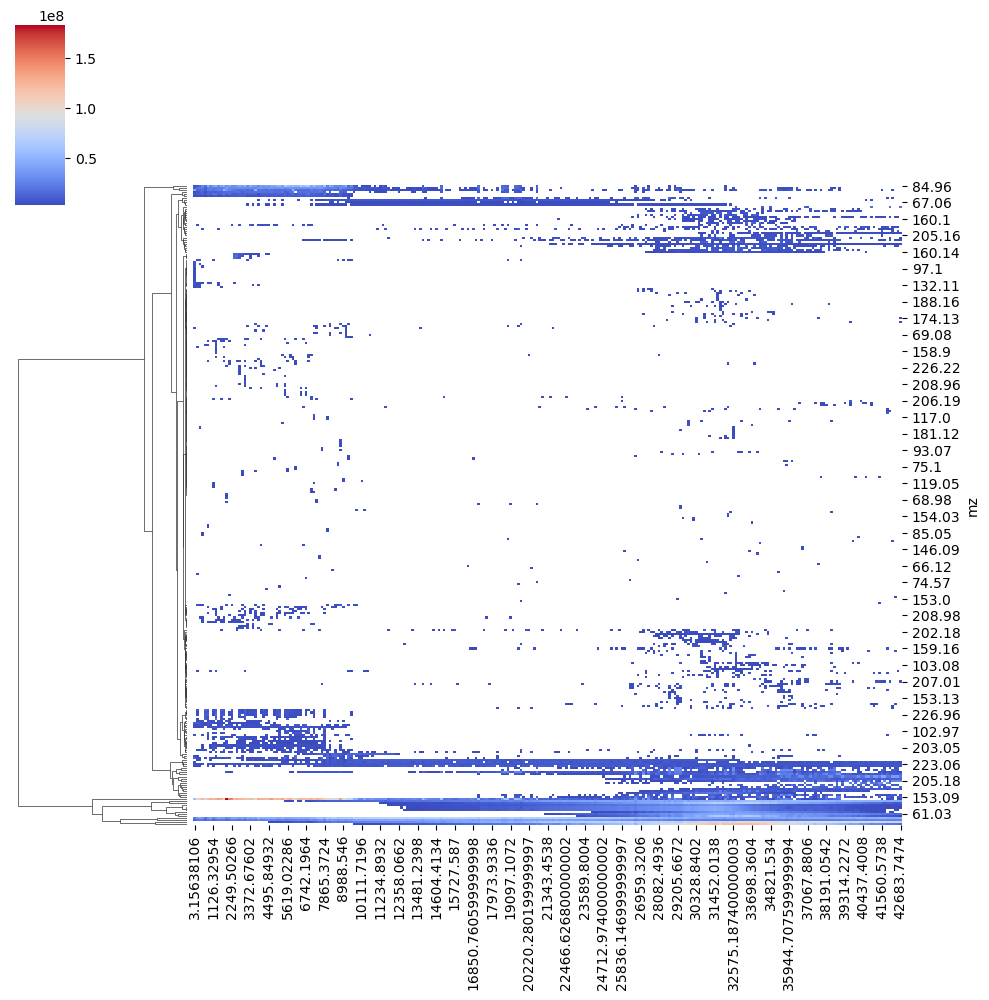

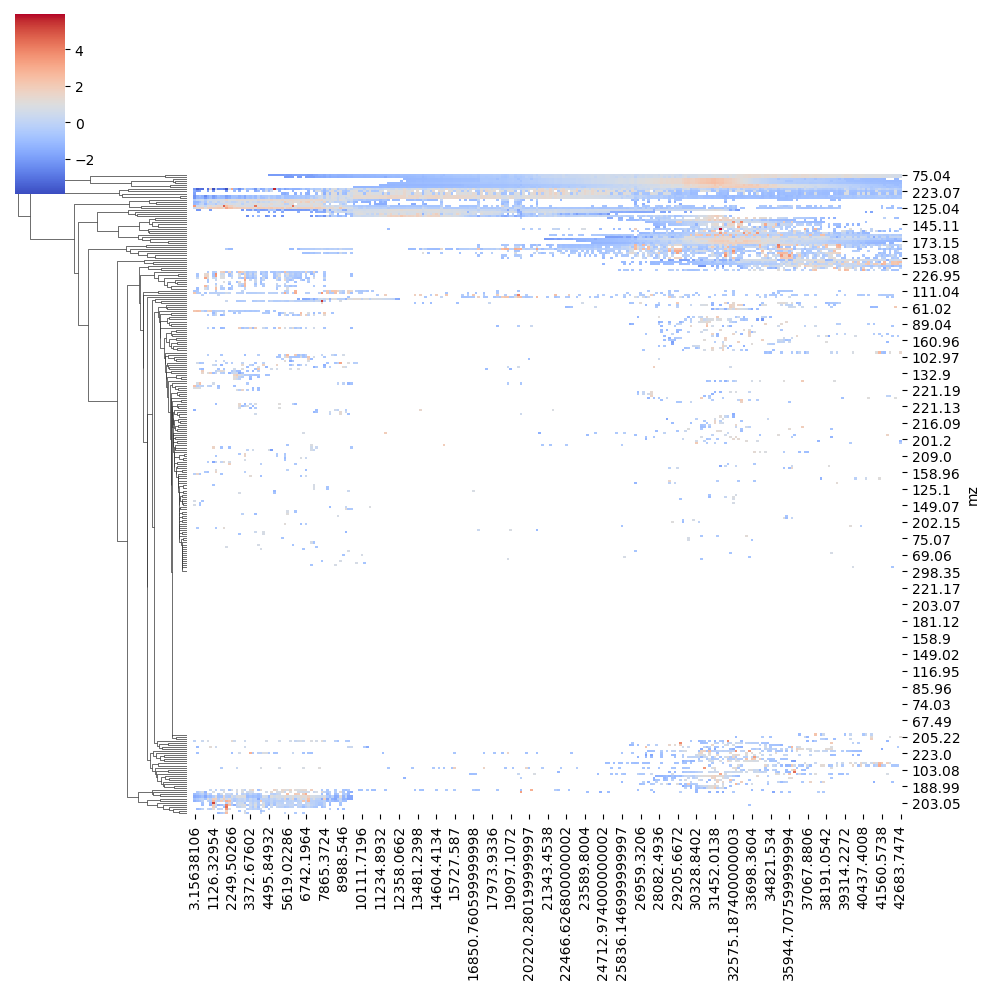

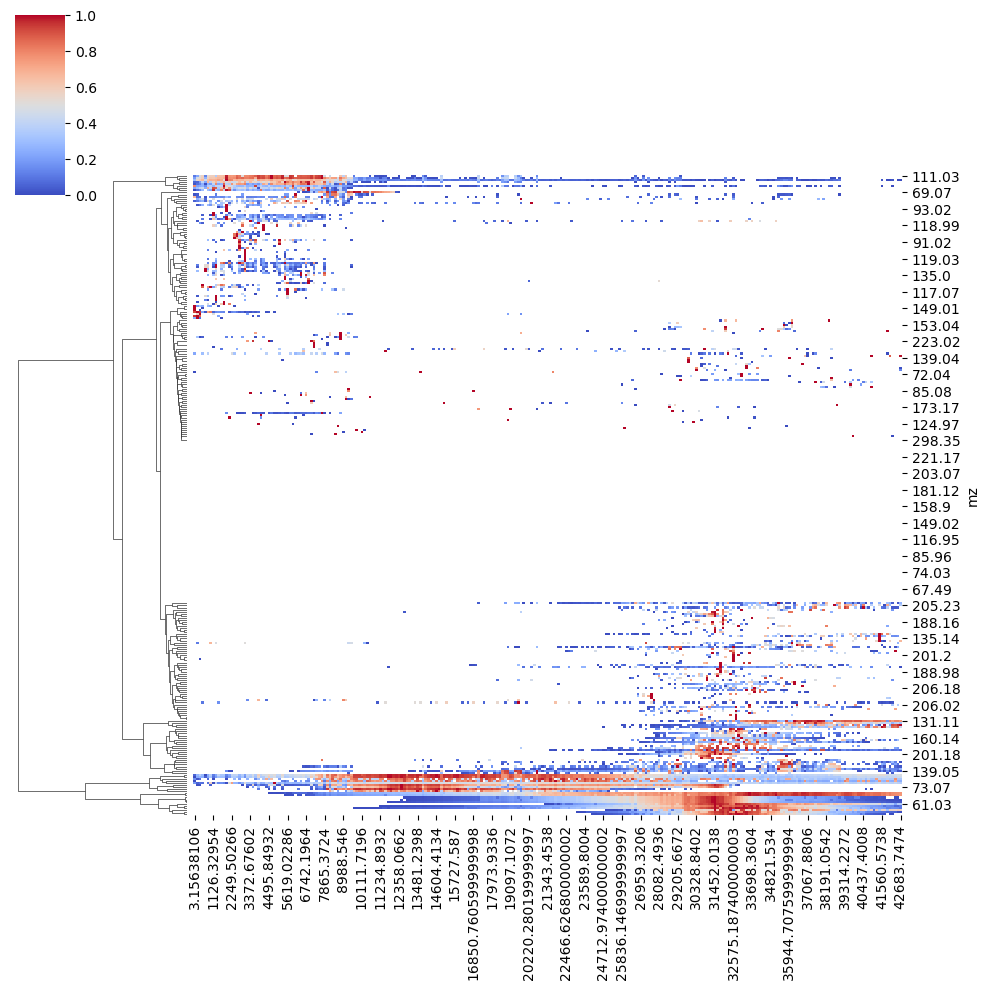

In [35]:
standardized_dataframe = formatted_data.z_score(inplace=False)
normalized_dataframe = formatted_data.normalize(inplace=False)

formatted_data.plot_clustermap(save_path=PROJECT_DIR.joinpath("Data/OrbiTrap/Converted/clustermap.png"))
formatted_data.plot_clustermap(df=standardized_dataframe, save_path=PROJECT_DIR.joinpath("Data/OrbiTrap/Converted/clustermap_standardized.png"))
formatted_data.plot_clustermap(df=normalized_dataframe, save_path=PROJECT_DIR.joinpath("Data/OrbiTrap/Converted/clustermap_normalized.png"))

### Step 3.4: Export the data
The data pipeline and tools provided by `orbitrapanalyis` are not meant to fully replace your existing workflow, but rather augment it. Because of this you can easily export your data to a .csv file at any time and continue working with it in your preferred software.
*Tip:* The .csv export works for both `ExpData` and `FormattedData` with the `export()` method respectively, but also for any type of dataframe: `export_to_csv(df, "/some/file/path/file.csv")`

In [ ]:
formatted_data.export(PROJECT_DIR.joinpath("Data/OrbiTrap/Converted/fermentation.csv"))